In [1]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 16
shuffle = True
seed = None

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

monitor = "val_accuracy"

In [2]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef

import math

import matplotlib.pyplot as plt

In [3]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [5]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

In [6]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

In [7]:
# ##################################################################################
# ##### Function to customize the DLNN architecture with parameters
# ##################################################################################

# def DLNN_CORENup(input_seq_shape = (41, 21),
#                  conv_filters_per_layer_1 = 10, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
#                  max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
#                  lstm_decode_units = 15, ## LSTM layer parameters
#                  conv_filters_per_layer_2 = 10,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
#                  max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
#                  dense_decode_units = 128, ## Dense layer parameters
#                  prob = 0.5, learn_rate = 0.0005, 
#                  loss = 'binary_crossentropy', metrics = 'accuracy'):
    
#     beta = 0.001
    
#     ######################################################################################################
#     ########  SEQUENCE  ##################################################################################
#     ######################################################################################################
    
#     input1 = tf.keras.layers.Input(shape=input_seq_shape)

#     x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
#                                 strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = "same")(input1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
#     x1 = tf.keras.layers.Dropout(prob)(x1)
    
#     x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)

#     ## LSTM Path

#     x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
#     x2 = tf.keras.layers.Dropout(prob)(x2)
    
#     x2 = tf.keras.layers.Flatten()(x2)
    
#     x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)

#     ## Conv Path

#     x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
#     x3 = tf.keras.layers.Activation('relu')(x3)
#     x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
#     x3 = tf.keras.layers.Dropout(prob)(x3)
    
#     x3 = tf.keras.layers.Flatten()(x3)
    
#     x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    
#     x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
#     ######################################################################################################
#     ########  Classifier  ################################################################################
#     ######################################################################################################
    
#     y = tf.keras.layers.Dense(dense_decode_units, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'relu')(x4)
    
#     y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    
#     y = tf.keras.layers.Dropout(prob)(y)
    
#     y = tf.keras.layers.Dense(1, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'sigmoid')(y)

#     ## Generate Model from input and output
#     model = tf.keras.models.Model(inputs=input1, outputs=y)
    
#     ## Compile model
#     if(metrics != None):
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
#     else:
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

#     return model

In [8]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 25, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
                 lstm_decode_units = 25, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 25,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
                 dense_decode_units = 256, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, 
                 loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)
    
    x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)
    
    x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

    return model

In [10]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 25)       5275        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 25)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 13, 25)       0           ['activation[0][0]']             
                                                                                              

# Training

In [11]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
train_data.head()

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

features = np.array(list(train_data['OHE_Sequence']))
labels = np.array(list(train_data['label']))
labels = labels.reshape((labels.shape[0], 1))

input_seq_shape = features[0].shape

folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

In [12]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

    
train_history = []

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = monitor, verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    h = model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], 
                  batch_size = batch_size, epochs = epochs, 
                  verbose = 1, callbacks = modelCallbacks, 
                  validation_data = (fold["X_test"], fold["y_test"]))
    
    train_history.append(h)
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.0744 - accuracy: 0.4992
Epoch 1: val_accuracy improved from -inf to 0.51572, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold0.hdf5
120/120 [==============================] - 6s 14ms/step - loss: 1.0744 - accuracy: 0.4992 - val_loss: 1.0155 - val_accuracy: 0.5157
Epoch 2/100
116/120 [============================>.] - ETA: 0s - loss: 0.9926 - accuracy: 0.5318
Epoch 2: val_accuracy improved from 0.51572 to 0.60587, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold0.hdf5
120/120 [==============================] - 1s 10ms/step - loss: 0.9915 - accuracy: 0.5339 - val_loss: 0.9252 - val_accuracy: 0.6059
Epoch 3/100
115/120 [===========================>..] - ETA: 0s - loss: 0.8642 - accuracy: 0.6533
Epoch 3: val_accuracy improved from 0.60587 to 0.70650, saving model

120/120 [==============================] - 1s 10ms/step - loss: 0.3098 - accuracy: 0.9003 - val_loss: 0.5264 - val_accuracy: 0.8050
Epoch 54/100
114/120 [===========================>..] - ETA: 0s - loss: 0.3150 - accuracy: 0.8893
Epoch 54: val_accuracy did not improve from 0.80503
120/120 [==============================] - 1s 9ms/step - loss: 0.3144 - accuracy: 0.8908 - val_loss: 0.5885 - val_accuracy: 0.7966
Epoch 55/100
117/120 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8974
Epoch 55: val_accuracy did not improve from 0.80503
120/120 [==============================] - 1s 9ms/step - loss: 0.3129 - accuracy: 0.8982 - val_loss: 0.5592 - val_accuracy: 0.7883
Epoch 56/100
117/120 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.9033
Epoch 56: val_accuracy did not improve from 0.80503
120/120 [==============================] - 1s 9ms/step - loss: 0.3169 - accuracy: 0.9034 - val_loss: 0.5430 - val_accuracy: 0.7904
Epoch 57/100
115/120 [===

120/120 [==============================] - 1s 9ms/step - loss: 0.6496 - accuracy: 0.7643 - val_loss: 0.6371 - val_accuracy: 0.7463
Epoch 10/100
116/120 [============================>.] - ETA: 0s - loss: 0.6159 - accuracy: 0.7694
Epoch 10: val_accuracy did not improve from 0.75262
120/120 [==============================] - 1s 9ms/step - loss: 0.6170 - accuracy: 0.7685 - val_loss: 0.6306 - val_accuracy: 0.7442
Epoch 11/100
117/120 [============================>.] - ETA: 0s - loss: 0.6016 - accuracy: 0.7837
Epoch 11: val_accuracy improved from 0.75262 to 0.75891, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold1.hdf5
120/120 [==============================] - 1s 9ms/step - loss: 0.5993 - accuracy: 0.7853 - val_loss: 0.6211 - val_accuracy: 0.7589
Epoch 12/100
119/120 [============================>.] - ETA: 0s - loss: 0.5842 - accuracy: 0.7936
Epoch 12: val_accuracy improved from 0.75891 to 0.77149, saving model to Results\NT_S

120/120 [==============================] - 1s 10ms/step - loss: 0.3969 - accuracy: 0.8604 - val_loss: 0.5600 - val_accuracy: 0.7904
Epoch 37/100
117/120 [============================>.] - ETA: 0s - loss: 0.3796 - accuracy: 0.8675
Epoch 37: val_accuracy did not improve from 0.79036
120/120 [==============================] - 1s 9ms/step - loss: 0.3787 - accuracy: 0.8677 - val_loss: 0.5828 - val_accuracy: 0.7673
Epoch 38/100
116/120 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.8869
Epoch 38: val_accuracy did not improve from 0.79036
120/120 [==============================] - 1s 9ms/step - loss: 0.3705 - accuracy: 0.8845 - val_loss: 0.5500 - val_accuracy: 0.7736
Epoch 39/100
120/120 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.8824
Epoch 39: val_accuracy did not improve from 0.79036
120/120 [==============================] - 1s 9ms/step - loss: 0.3637 - accuracy: 0.8824 - val_loss: 0.5493 - val_accuracy: 0.7736
Epoch 40/100
120/120 [===

120/120 [==============================] - 1s 9ms/step - loss: 0.2772 - accuracy: 0.9213 - val_loss: 0.5612 - val_accuracy: 0.7945
Epoch 93/100
116/120 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.9100
Epoch 93: val_accuracy did not improve from 0.80713
120/120 [==============================] - 1s 9ms/step - loss: 0.2984 - accuracy: 0.9113 - val_loss: 0.5681 - val_accuracy: 0.7987
Epoch 94/100
116/120 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.9154
Epoch 94: val_accuracy did not improve from 0.80713
120/120 [==============================] - 1s 9ms/step - loss: 0.2941 - accuracy: 0.9150 - val_loss: 0.5524 - val_accuracy: 0.7966
Epoch 95/100
115/120 [===========================>..] - ETA: 0s - loss: 0.2875 - accuracy: 0.9130
Epoch 95: val_accuracy did not improve from 0.80713
120/120 [==============================] - 1s 9ms/step - loss: 0.2839 - accuracy: 0.9144 - val_loss: 0.5784 - val_accuracy: 0.8050
Epoch 96/100
117/120 [====

120/120 [==============================] - 1s 9ms/step - loss: 0.4947 - accuracy: 0.8122 - val_loss: 0.5775 - val_accuracy: 0.7815
Epoch 19/100
119/120 [============================>.] - ETA: 0s - loss: 0.4867 - accuracy: 0.8209
Epoch 19: val_accuracy did not improve from 0.78151
120/120 [==============================] - 1s 9ms/step - loss: 0.4868 - accuracy: 0.8206 - val_loss: 0.6168 - val_accuracy: 0.7647
Epoch 20/100
115/120 [===========================>..] - ETA: 0s - loss: 0.4688 - accuracy: 0.8190
Epoch 20: val_accuracy improved from 0.78151 to 0.78361, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold2.hdf5
120/120 [==============================] - 1s 9ms/step - loss: 0.4670 - accuracy: 0.8211 - val_loss: 0.5814 - val_accuracy: 0.7836
Epoch 21/100
119/120 [============================>.] - ETA: 0s - loss: 0.4531 - accuracy: 0.8482
Epoch 21: val_accuracy improved from 0.78361 to 0.78782, saving model to Results\NT_S

120/120 [==============================] - 1s 9ms/step - loss: 0.3635 - accuracy: 0.8720 - val_loss: 0.5541 - val_accuracy: 0.8025
Epoch 46/100
119/120 [============================>.] - ETA: 0s - loss: 0.3321 - accuracy: 0.8923
Epoch 46: val_accuracy did not improve from 0.80252
120/120 [==============================] - 1s 9ms/step - loss: 0.3319 - accuracy: 0.8924 - val_loss: 0.5499 - val_accuracy: 0.7983
Epoch 47/100
118/120 [============================>.] - ETA: 0s - loss: 0.3296 - accuracy: 0.8882
Epoch 47: val_accuracy improved from 0.80252 to 0.80462, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold2.hdf5
120/120 [==============================] - 1s 9ms/step - loss: 0.3285 - accuracy: 0.8888 - val_loss: 0.5649 - val_accuracy: 0.8046
Epoch 48/100
117/120 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.8985
Epoch 48: val_accuracy did not improve from 0.80462
120/120 [========================

Epoch 73/100
117/120 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.9119
Epoch 73: val_accuracy did not improve from 0.81933
120/120 [==============================] - 1s 9ms/step - loss: 0.3083 - accuracy: 0.9119 - val_loss: 0.5520 - val_accuracy: 0.7983
Epoch 74/100
119/120 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.9181
Epoch 74: val_accuracy did not improve from 0.81933
120/120 [==============================] - 1s 9ms/step - loss: 0.2817 - accuracy: 0.9182 - val_loss: 0.5989 - val_accuracy: 0.7962
Epoch 75/100
117/120 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.9119
Epoch 75: val_accuracy did not improve from 0.81933
120/120 [==============================] - 1s 9ms/step - loss: 0.2997 - accuracy: 0.9129 - val_loss: 0.5791 - val_accuracy: 0.7983
Epoch 76/100
120/120 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.9066
Epoch 76: val_accuracy did not improve from 0.81933
120/120

120/120 [==============================] - 3s 12ms/step - loss: 1.0816 - accuracy: 0.5100 - val_loss: 1.0136 - val_accuracy: 0.5084
Epoch 2/100
113/120 [===========================>..] - ETA: 0s - loss: 1.0005 - accuracy: 0.5343
Epoch 2: val_accuracy improved from 0.50840 to 0.57563, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold3.hdf5
120/120 [==============================] - 1s 9ms/step - loss: 0.9961 - accuracy: 0.5414 - val_loss: 0.9381 - val_accuracy: 0.5756
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.6301
Epoch 3: val_accuracy improved from 0.57563 to 0.69328, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold3.hdf5
120/120 [==============================] - 1s 9ms/step - loss: 0.8906 - accuracy: 0.6301 - val_loss: 0.8038 - val_accuracy: 0.6933
Epoch 4/100
119/120 [============================>.] - ETA: 0s

Epoch 25/100
114/120 [===========================>..] - ETA: 0s - loss: 0.4451 - accuracy: 0.8459
Epoch 25: val_accuracy did not improve from 0.78361
120/120 [==============================] - 1s 9ms/step - loss: 0.4403 - accuracy: 0.8473 - val_loss: 0.5532 - val_accuracy: 0.7731
Epoch 26/100
116/120 [============================>.] - ETA: 0s - loss: 0.4311 - accuracy: 0.8470
Epoch 26: val_accuracy improved from 0.78361 to 0.78992, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold3.hdf5
120/120 [==============================] - 1s 10ms/step - loss: 0.4281 - accuracy: 0.8478 - val_loss: 0.5360 - val_accuracy: 0.7899
Epoch 27/100
118/120 [============================>.] - ETA: 0s - loss: 0.4187 - accuracy: 0.8422
Epoch 27: val_accuracy did not improve from 0.78992
120/120 [==============================] - 1s 9ms/step - loss: 0.4194 - accuracy: 0.8421 - val_loss: 0.5411 - val_accuracy: 0.7836
Epoch 28/100
117/120 [==========

120/120 [==============================] - 1s 9ms/step - loss: 0.3350 - accuracy: 0.8830 - val_loss: 0.5780 - val_accuracy: 0.8046
Epoch 53/100
119/120 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8881
Epoch 53: val_accuracy did not improve from 0.80672
120/120 [==============================] - 1s 9ms/step - loss: 0.3390 - accuracy: 0.8877 - val_loss: 0.5572 - val_accuracy: 0.7941
Epoch 54/100
115/120 [===========================>..] - ETA: 0s - loss: 0.3346 - accuracy: 0.8837
Epoch 54: val_accuracy did not improve from 0.80672
120/120 [==============================] - 1s 9ms/step - loss: 0.3357 - accuracy: 0.8835 - val_loss: 0.6004 - val_accuracy: 0.7878
Epoch 55/100
117/120 [============================>.] - ETA: 0s - loss: 0.3304 - accuracy: 0.8900
Epoch 55: val_accuracy did not improve from 0.80672
120/120 [==============================] - 1s 9ms/step - loss: 0.3322 - accuracy: 0.8893 - val_loss: 0.5372 - val_accuracy: 0.7920
Epoch 56/100
114/120 [====

Epoch 82/100
115/120 [===========================>..] - ETA: 0s - loss: 0.3097 - accuracy: 0.8957
Epoch 82: val_accuracy did not improve from 0.80672
120/120 [==============================] - 1s 9ms/step - loss: 0.3130 - accuracy: 0.8930 - val_loss: 0.6053 - val_accuracy: 0.7983
Epoch 83/100
116/120 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.9084
Epoch 83: val_accuracy did not improve from 0.80672
120/120 [==============================] - 1s 9ms/step - loss: 0.3039 - accuracy: 0.9071 - val_loss: 0.5536 - val_accuracy: 0.7941
Epoch 84/100
120/120 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.9092
Epoch 84: val_accuracy did not improve from 0.80672
120/120 [==============================] - 1s 9ms/step - loss: 0.2998 - accuracy: 0.9092 - val_loss: 0.5484 - val_accuracy: 0.7899
Epoch 85/100
120/120 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.9108
Epoch 85: val_accuracy did not improve from 0.80672
120/120

Epoch 36/100
120/120 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8510
Epoch 36: val_accuracy did not improve from 0.79832
120/120 [==============================] - 1s 9ms/step - loss: 0.3860 - accuracy: 0.8510 - val_loss: 0.5216 - val_accuracy: 0.7710
Epoch 37/100
119/120 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8834
Epoch 37: val_accuracy did not improve from 0.79832
120/120 [==============================] - 1s 9ms/step - loss: 0.3414 - accuracy: 0.8835 - val_loss: 0.5504 - val_accuracy: 0.7584
Epoch 38/100
118/120 [============================>.] - ETA: 0s - loss: 0.3722 - accuracy: 0.8692
Epoch 38: val_accuracy did not improve from 0.79832
120/120 [==============================] - 1s 9ms/step - loss: 0.3713 - accuracy: 0.8699 - val_loss: 0.5322 - val_accuracy: 0.7689
Epoch 39/100
115/120 [===========================>..] - ETA: 0s - loss: 0.3673 - accuracy: 0.8734
Epoch 39: val_accuracy did not improve from 0.79832
120/120

120/120 [==============================] - 1s 8ms/step - loss: 0.3108 - accuracy: 0.9008 - val_loss: 0.5634 - val_accuracy: 0.7815
Epoch 64/100
115/120 [===========================>..] - ETA: 0s - loss: 0.3069 - accuracy: 0.9022
Epoch 64: val_accuracy did not improve from 0.81303
120/120 [==============================] - 1s 8ms/step - loss: 0.3120 - accuracy: 0.8998 - val_loss: 0.5333 - val_accuracy: 0.7983
Epoch 65/100
117/120 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.9022
Epoch 65: val_accuracy did not improve from 0.81303
120/120 [==============================] - 1s 8ms/step - loss: 0.3167 - accuracy: 0.9024 - val_loss: 0.5547 - val_accuracy: 0.7962
Epoch 66/100
118/120 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8946
Epoch 66: val_accuracy did not improve from 0.81303
120/120 [==============================] - 1s 9ms/step - loss: 0.3341 - accuracy: 0.8945 - val_loss: 0.5365 - val_accuracy: 0.7962
Epoch 67/100
117/120 [====

Epoch 93/100
114/120 [===========================>..] - ETA: 0s - loss: 0.2967 - accuracy: 0.9079
Epoch 93: val_accuracy did not improve from 0.81303
120/120 [==============================] - 1s 9ms/step - loss: 0.2939 - accuracy: 0.9092 - val_loss: 0.5653 - val_accuracy: 0.7941
Epoch 94/100
117/120 [============================>.] - ETA: 0s - loss: 0.2908 - accuracy: 0.9124
Epoch 94: val_accuracy improved from 0.81303 to 0.81723, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\bestModel-fold4.hdf5
120/120 [==============================] - 1s 9ms/step - loss: 0.2946 - accuracy: 0.9108 - val_loss: 0.5570 - val_accuracy: 0.8172
Epoch 95/100
115/120 [===========================>..] - ETA: 0s - loss: 0.2783 - accuracy: 0.9190
Epoch 95: val_accuracy did not improve from 0.81723
120/120 [==============================] - 1s 9ms/step - loss: 0.2820 - accuracy: 0.9171 - val_loss: 0.5719 - val_accuracy: 0.7983
Epoch 96/100
115/120 [===========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


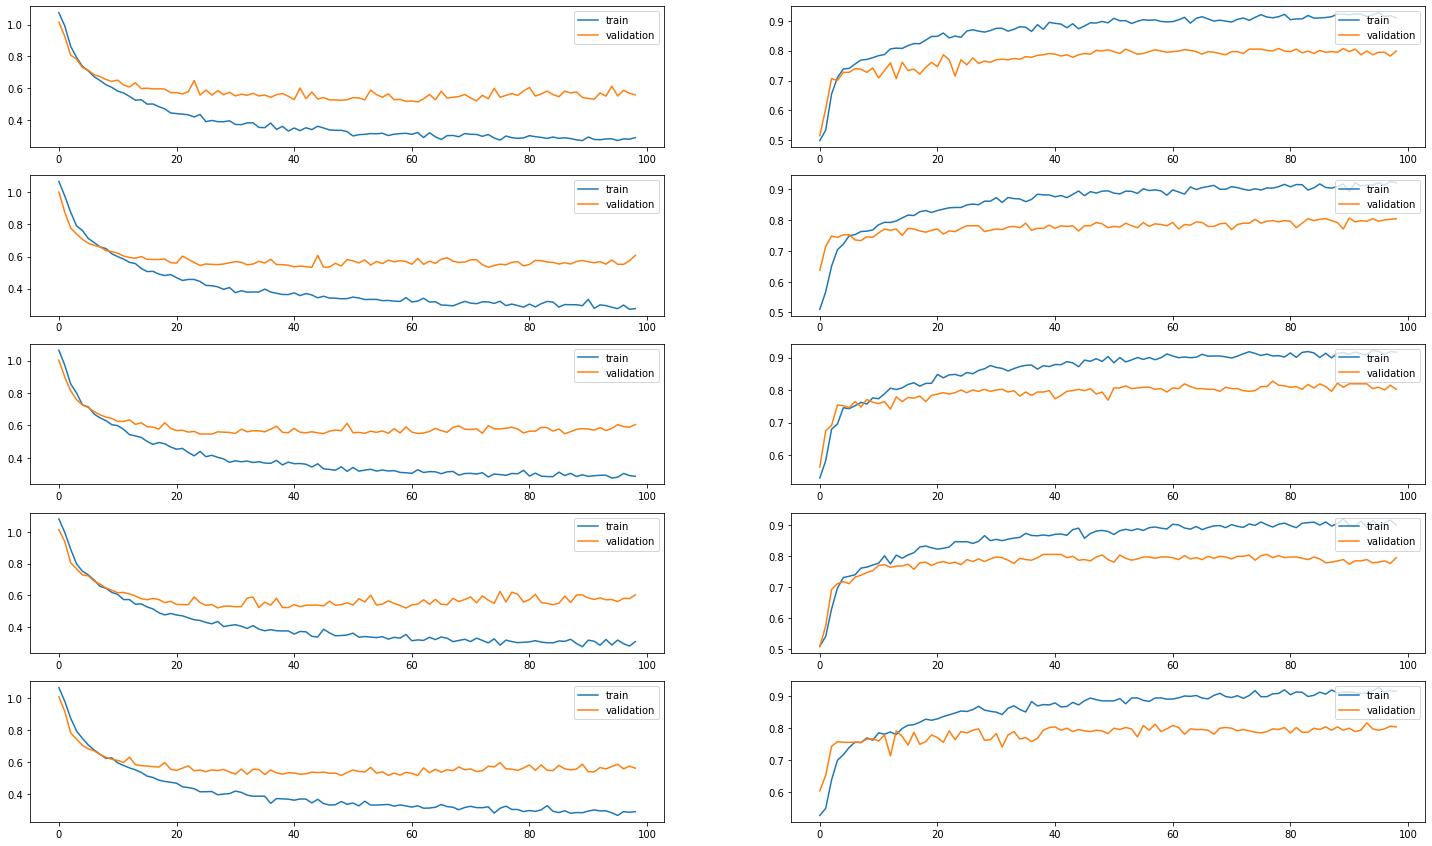

In [35]:
fold_to_show = 0
H = train_history[fold_to_show]

print(H.history.keys())

zoom_start, zoom_end = 0, -1

f, axarr = plt.subplots(len(train_history), 2, figsize=(25, 15))

i=-1
for H in train_history:
    
    i += 1
    
    # "Loss"
    title = 'enc model loss '+str(i)
    axarr[i, 0].plot(H.history['loss'][zoom_start:zoom_end])
    axarr[i, 0].plot(H.history['val_loss'][zoom_start:zoom_end])
#     axarr[i, 0].title(title)
#     axarr[i, 0].ylabel('loss')
#     axarr[i, 0].xlabel('epoch')
    axarr[i, 0].legend(['train', 'validation'], loc='upper right')
#     axarr[i, 0].show()

    # "accuracy"
    title = 'model accuracy '+str(i)
    axarr[i, 1].plot(H.history['accuracy'][zoom_start:zoom_end])
    axarr[i, 1].plot(H.history['val_accuracy'][zoom_start:zoom_end])
#     axarr[i, 1].title(title)
#     axarr[i, 1].ylabel('accuracy')
#     axarr[i, 1].xlabel('epoch')
    axarr[i, 1].legend(['train', 'validation'], loc='upper right')
#     axarr[i, 1].show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


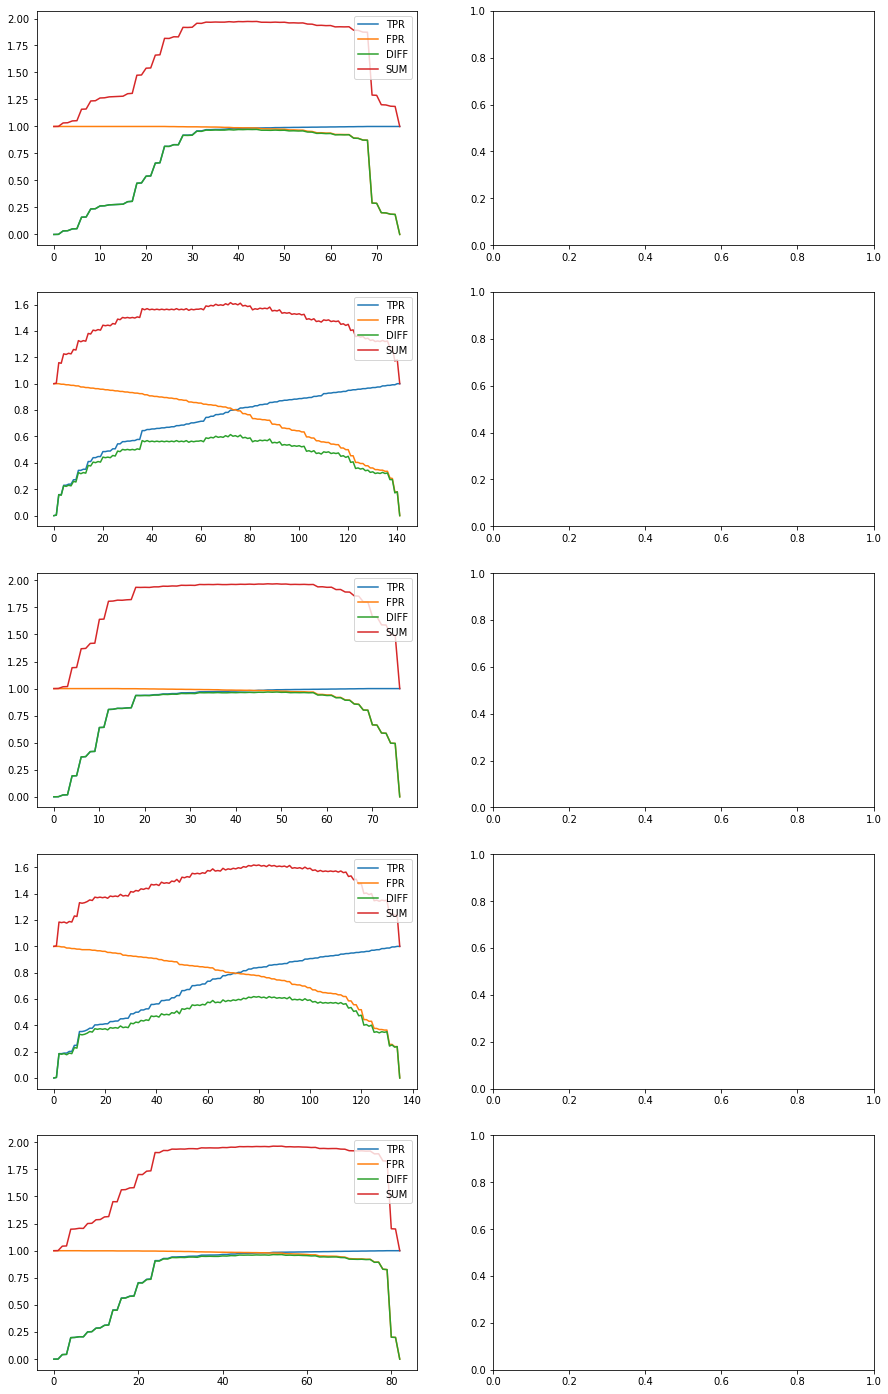

In [19]:
fold_to_show = 0
H = train_history[fold_to_show]

print(H.history.keys())

zoom_start, zoom_end = 0, -1

f, axarr = plt.subplots(len(train_history), 2, figsize=(15, 25))

i=-1
for H in train_history:
    
    i += 1
    
    # "Loss"
    title = 'enc model loss '+str(i)
    axarr[i, 0].plot(evaluations_df['TPR'][i])
    axarr[i, 0].plot(1-evaluations_df['FPR'][i])
    axarr[i, 0].plot(evaluations_df['TPR'][i] - evaluations_df['FPR'][i])
    axarr[i, 0].plot(evaluations_df['TPR'][i] + (1-evaluations_df['FPR'][i]))
    
#     axarr[i, 0].title(title)
#     axarr[i, 0].ylabel('loss')
#     axarr[i, 0].xlabel('epoch')
    axarr[i, 0].legend(['TPR', 'FPR', 'DIFF', 'SUM'], loc='upper right')
#     axarr[i, 0].show()

#     # "accuracy"
#     title = 'model accuracy '+str(i)
#     axarr[i, 1].plot(H.history['accuracy'][zoom_start:zoom_end])
#     axarr[i, 1].plot(H.history['val_accuracy'][zoom_start:zoom_end])
# #     axarr[i, 1].title(title)
# #     axarr[i, 1].ylabel('accuracy')
# #     axarr[i, 1].xlabel('epoch')
#     axarr[i, 1].legend(['train', 'validation'], loc='upper right')
# #     axarr[i, 1].show()

## k-fold Training evaluation

In [14]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.813187,0.811647,0.875989,0.816975,0.809444,0.627049
Train,0.977541,0.975004,0.996021,0.980270,0.974811,0.955145


In [36]:
evaluations_df.groupby(["Train_Test"]).std().filter(['Accuracy', 
                                                       'Precision', 
                                                       'AUC', 
                                                       'Sensitivity', 
                                                       'Specificity', 
                                                       'MCC'])

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.009261,0.021729,0.003479,0.021369,0.031282,0.018192
Train,0.013926,0.015032,0.005308,0.014790,0.015242,0.027862


In [16]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.807128,0.812766,"[0.0, 0.0041841004184100415, 0.158995815899581...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9997988, 0.99979883, 0.9940766, 0.9940447, ...",0.875286,0.799163,0.815126,0.614354
3,1,Test,0.807128,0.780769,"[0.0, 0.004201680672268907, 0.1848739495798319...","[0.0, 0.0, 0.0, 0.0041841004184100415, 0.00418...","[1.9998988, 0.9998988, 0.991334, 0.9907355, 0....",0.876551,0.852941,0.761506,0.616958
5,2,Test,0.827731,0.836207,"[0.0, 0.004201680672268907, 0.0168067226890756...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9998504, 0.9998504, 0.9997311, 0.99963415, ...",0.878469,0.815126,0.840336,0.655671
7,3,Test,0.806723,0.801653,"[0.0, 0.004201680672268907, 0.0924369747899159...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9960063, 0.9960062, 0.9707539, 0.9705886, 0...",0.870419,0.815126,0.798319,0.613532
9,4,Test,0.817227,0.826840,"[0.0, 0.004201680672268907, 0.2226890756302521...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.004201680672268907...","[1.9990383, 0.99903834, 0.98024017, 0.9800229,...",0.879219,0.802521,0.831933,0.634728


# Independent data

In [20]:
train_features = features
train_labels = labels

In [21]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
indpe_data.head()
    
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

input_seq_shape = indpe_features[0].shape

## Using k-fold Models

### Performance of each k-fold model

In [22]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    indpe_evaluations["Fold"].append(i)
    indpe_evaluations["Train_Test"].append("Independent")
    indpe_evaluations["Accuracy"].append(acc)
    indpe_evaluations["Precision"].append(prec)
    indpe_evaluations["TPR"].append(tpr)
    indpe_evaluations["FPR"].append(fpr)
    indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
    indpe_evaluations["AUC"].append(auc)
    indpe_evaluations["Sensitivity"].append(sens)
    indpe_evaluations["Specificity"].append(spec)
    indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.640653,0.261738,0.680056,0.640394,0.640705,0.213138


In [23]:
indpe_evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.645714,0.265720,"[0.0, 0.0, 0.0, 0.009852216748768473, 0.009852...","[0.0, 0.0009784735812133072, 0.001956947162426...","[1.9999231, 0.9999231, 0.99982893, 0.9997907, ...",0.681606,0.645320,0.645793,0.220727
1,1,Independent,0.615510,0.256364,"[0.0, 0.0, 0.0, 0.0049261083743842365, 0.00492...","[0.0, 0.0009784735812133072, 0.001956947162426...","[1.9998456, 0.9998456, 0.9996251, 0.99955064, ...",0.682835,0.694581,0.599804,0.220068
2,2,Independent,0.655510,0.260394,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.004892367906066536, 0.00489236790...","[1.9998349, 0.9998349, 0.9996153, 0.9992594, 0...",0.674342,0.586207,0.669276,0.196425
3,3,Independent,0.626939,0.251953,"[0.0, 0.0049261083743842365, 0.009852216748768...","[0.0, 0.0, 0.0, 0.0029354207436399216, 0.00293...","[1.9963887, 0.9963887, 0.99315476, 0.98965734,...",0.671594,0.635468,0.625245,0.196542
4,4,Independent,0.659592,0.274262,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0019569471624266144, 0.0019569471...","[1.9996158, 0.9996158, 0.9993112, 0.9987399, 0...",0.689901,0.640394,0.663405,0.231927


### Mean score with k-fold models

In [24]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

indpe_evaluations["Fold"].append(i)
indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.657959,0.275,0.693,0.650246,0.659491,0.235922


In [25]:
indpe_evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,4,Independent,0.657959,0.275,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0019569471624266144, 0.0019569471...","[1.999041199684143, 0.9990411996841431, 0.9976...",0.693,0.650246,0.659491,0.235922


### Voting score with k-fold models

In [26]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.663673,0.28,0.682189,0.655172,0.665362,0.244608


In [27]:
indpe_evaluations_df

,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,Independent,0.663673,0.28,"[0.0, 0.4630541871921182, 0.5763546798029556, ...","[0.0, 0.19667318982387474, 0.2827788649706458,...","[2.0, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0]",0.682189,0.655172,0.665362,0.244608


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [ ]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 25, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
                 lstm_decode_units = 25, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 25,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
                 dense_decode_units = 256, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, 
                 loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)
    
    x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)
    
    x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

    return model

In [28]:
pos_indexes = np.where(indpe_labels==1)[0]
neg_indexes = np.random.permutation(np.where(indpe_labels==0)[0])[0:pos_indexes.shape[0]]
indpe_val_indexes = np.concatenate((pos_indexes, neg_indexes))

In [47]:
model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = monitor, verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

H = model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
                    batch_size = batch_size, epochs = epochs, 
                    verbose = 1, callbacks = modelCallbacks, 
                    validation_data = (indpe_features[indpe_val_indexes], indpe_labels[indpe_val_indexes]))
# H = model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
#                     batch_size = batch_size, epochs = epochs, 
#                     verbose = 1, callbacks = modelCallbacks, 
#                     validation_data = (indpe_features, indpe_labels))
# model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_split = 0.2)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
149/149 [==============================] - ETA: 0s - loss: 1.0673 - accuracy: 0.5109
Epoch 1: val_accuracy improved from -inf to 0.50739, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\_fullModel.hdf5
149/149 [==============================] - 4s 12ms/step - loss: 1.0673 - accuracy: 0.5109 - val_loss: 1.0051 - val_accuracy: 0.5074
Epoch 2/100
144/149 [===========================>..] - ETA: 0s - loss: 0.9415 - accuracy: 0.6068
Epoch 2: val_accuracy improved from 0.50739 to 0.58128, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise\5fold\models\_fullModel.hdf5
149/149 [==============================] - 1s 9ms/step - loss: 0.9416 - accuracy: 0.6066 - val_loss: 0.9305 - val_accuracy: 0.5813
Epoch 3/100
146/149 [============================>.] - ETA: 0s - loss: 0.8265 - accuracy: 0.6978
Epoch 3: val_accuracy did not improve from 0.58128
149/149 [==============================] - 1s 9ms/step - l

147/149 [============================>.] - ETA: 0s - loss: 0.3453 - accuracy: 0.8784
Epoch 57: val_accuracy did not improve from 0.63793
149/149 [==============================] - 1s 9ms/step - loss: 0.3441 - accuracy: 0.8795 - val_loss: 0.9499 - val_accuracy: 0.6281
Epoch 58/100
144/149 [===========================>..] - ETA: 0s - loss: 0.3447 - accuracy: 0.8889
Epoch 58: val_accuracy did not improve from 0.63793
149/149 [==============================] - 1s 9ms/step - loss: 0.3432 - accuracy: 0.8883 - val_loss: 0.9518 - val_accuracy: 0.6207
Epoch 59/100
148/149 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8970
Epoch 59: val_accuracy did not improve from 0.63793
149/149 [==============================] - 1s 9ms/step - loss: 0.3257 - accuracy: 0.8971 - val_loss: 1.0257 - val_accuracy: 0.6256
Epoch 60/100
143/149 [===========================>..] - ETA: 0s - loss: 0.3309 - accuracy: 0.8942
Epoch 60: val_accuracy did not improve from 0.63793
149/149 [===========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


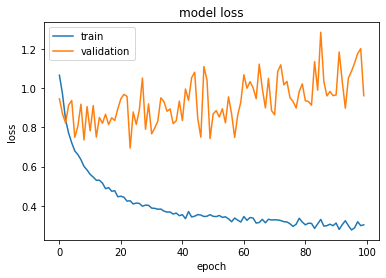

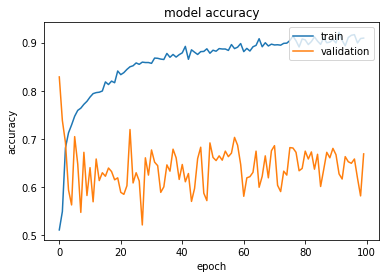

In [43]:
print(H.history.keys())

# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "accuracy"
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


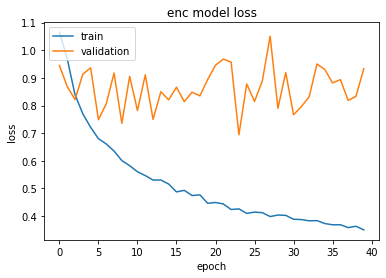

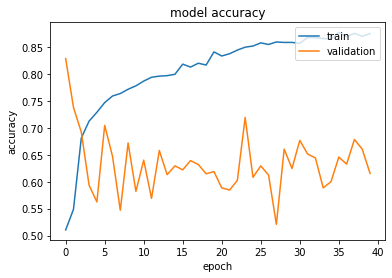

In [44]:
print(H.history.keys())

zoom_start, zoom_end = 0, 40

# "Loss"
plt.plot(H.history['loss'][zoom_start:zoom_end])
plt.plot(H.history['val_loss'][zoom_start:zoom_end])
plt.title('enc model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "accuracy"
plt.plot(H.history['accuracy'][zoom_start:zoom_end])
plt.plot(H.history['val_accuracy'][zoom_start:zoom_end])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [45]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.625306,0.253846,0.67091,0.650246,0.620352,0.203565


In [46]:
indpe_evaluations_df

,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,Independent,0.625306,0.253846,"[0.0, 0.0, 0.014778325123152709, 0.01477832512...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9997764, 0.9997763, 0.9992778, 0.9989366, 0...",0.67091,0.650246,0.620352,0.203565
